# Input scheme

Have everything as a variable so I can perturb it

1. Legacy reactor assumed lifetime
2. GEN3 LWR lifetime
3. What to deploy to meet demand
4. Energy demand
5. Ratio?

In [144]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'viridis'
import xmltodict
from pprint import pprint
import copy
src_path = './src'

def read_file_from_src(filename):
    return open(os.path.join(src_path, filename), 'r').read()

s = read_file_from_src('template.xml')
b_list = ['fuel_cycle_facilities.xml', 'reactors.xml', 'regions.xml', 'recipes.xml']
for i in b_list:
    temp = read_file_from_src(i)
    s = s.replace('$'+i, temp)

with open('eh.xml', 'w') as f:
    f.write(s)

In [145]:
d = xmltodict.parse(s)
def get_config_dict(d):
    power_dict = {}


    # get power dict
    for i in d['simulation']['facility']:
        if 'Reactor' in i['config'].keys():
            power_dict[i['name']] = float(i['config']['Reactor']['power_cap'])

    # get enter / lifetimes / n_builds
    deployed_dict = {}

    for reg in d['simulation']['region']:
        if not isinstance(reg['institution'], list):
            q = [reg['institution']]
        else:
            q = reg['institution']
        for i in q:
            deployed_dict[i['name']] = {'lifetime': [],
                     'prototype': [],
                     'n_build': [],
                     'build_times': []}
            for indx, val in enumerate(i['config']['DeployInst']['prototypes']['val']):
                if val in power_dict.keys():
                    deployed_dict[i['name']]['prototype'].append(val)
                    deployed_dict[i['name']]['lifetime'].append(int(i['config']['DeployInst']['lifetimes']['val'][indx]))
                    deployed_dict[i['name']]['n_build'].append(int(i['config']['DeployInst']['n_build']['val'][indx]))
                    deployed_dict[i['name']]['build_times'].append(int(i['config']['DeployInst']['build_times']['val'][indx]))
    return power_dict, deployed_dict


show


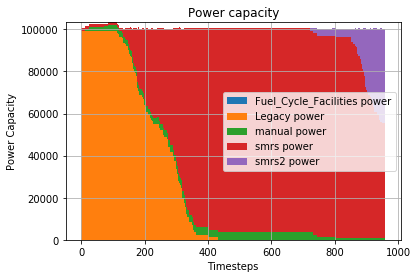

In [148]:
def legacy_lifetimes(extension_eq):
    new_xml = copy.deepcopy(d)
    # default has been 60 years = 720 timesteps
    for i in range(len(new_xml['simulation']['region'][1]['institution'][0]['config']['DeployInst']['lifetimes']['val'])):
        x = eval(extension_eq)
        new_xml['simulation']['region'][1]['institution'][0]['config']['DeployInst']['lifetimes']['val'][i] = str(int(new_xml['simulation']['region'][1]['institution'][0]['config']['DeployInst']['lifetimes']['val'][i]) + x)
    return new_xml

def get_deployed_power(power_dict, deployed_dict):
    t = np.arange(960)
    inst_power = {}
    for key, val in deployed_dict.items():
        inst_power[key] = np.zeros(len(t))
        for i, v in enumerate(val['prototype']):
            inst_power[key][deployed_dict[key]['build_times'][i] : deployed_dict[key]['build_times'][i] + deployed_dict[key]['lifetime'][i]] += power_dict[v] * deployed_dict[key]['n_build'][i]
    return t, inst_power
    

def deploy_to_meet_demand(d, a, z, demand_eq, proto_list, ratio_list, lifetime_list, newinst_name):
    filtered =  ''.join(x for x in demand_eq if x.isalpha())
    if len(filtered) != 0 and 'x' not in filtered:
        raise ValueError('The variable is `x`')
        
    power_dict, deployed_dict = get_config_dict(d)
    t, inst_power = get_deployed_power(power_dict, deployed_dict)
    power = np.zeros(960)
    for key, val in inst_power.items():
        power += val
    
    # find lack
    demand = np.zeros(len(t))
    demand[a:z] = [eval(demand_eq) for x in t[a:z]]
    lack = demand - power
    lack[0] = 0
    ratio_list = np.array(ratio_list)
    ratio_list = ratio_list / sum(ratio_list)
    lifetime_dict = {proto_list[i]: lifetime_list[i] for i, v in enumerate(lifetime_list)}
    deploy_dict = {k:np.zeros(len(t)) for k in proto_list}
    # split lack
    lack_dict = {proto_list[i]: lack * ratio_list[i] for i, v in enumerate(ratio_list)}
    
    for proto, l in lack_dict.items():
        p = config_dict['power'][config_dict['name'].index(proto)]
        life = lifetime_dict[proto]
        for indx in range(960):
            while lack_dict[proto][indx] > 0:
                deploy_dict[proto][indx] += 1
                lack_dict[proto][indx: indx+life] -= p
    
    append_d = {'name': newinst_name,
                'config': {'DeployInst': {'prototypes': {'val': []},
                                          'n_build': {'val': []},
                                          'build_times': {'val': []},
                                          'lifetimes': {'val': []}}
                            }
               }
    for key in deploy_dict:
        for indx, val in enumerate(deploy_dict[key]):
            if val == 0:
                continue
            append_d['config']['DeployInst']['prototypes']['val'].append(key)
            append_d['config']['DeployInst']['n_build']['val'].append(val)
            append_d['config']['DeployInst']['build_times']['val'].append(indx)
            append_d['config']['DeployInst']['lifetimes']['val'].append(lifetime_dict[key])

    new_xml = copy.deepcopy(d)
    new_xml['simulation']['region'][1]['institution'].append(append_d)
    return new_xml

def stacked_bar(x, y):
    fig = plt.figure()
    a2 = fig.add_subplot(111)
    prev = copy.deepcopy(np.zeros(960))
    for key, val in y.items():
        a2.bar(x, height=val, width=1, bottom=prev, label=key+' power')
        prev += val
    a2.set_title('Power capacity')
    a2.set_xlabel('Timesteps')
    a2.set_ylabel('Power Capacity')
    a2.grid()
    a2.legend()
    print('show')
    plt.show()
    


q = deploy_to_meet_demand(d, 0, 500, '100000', ['12_SMR', 'ABR'], [0.5, 0.5], [720, 720], 'smrs')
q = deploy_to_meet_demand(q, 500, 959, '100000', ['12_SMR'], [1], [720], 'smrs2')
power_dict, deployed_dict = get_config_dict(q)
#for indx, val in enumerate(deployed_dict['prototype']):
#    print(val, deployed_dict['n_build'][indx])

t, power = get_deployed_power(power_dict, deployed_dict)
stacked_bar(t, power)